# Merton Market Maker — Jump Diff Calibration + Online Replay Experiments

Workflow:

1. Load/resample historical prices
2. Run offline Merton MLE calibration
3. Replay prices through C++ online calibrator
4. Compare fair value vs market and monitor parameter drift

In [ ]:
import math
import os
from datetime import datetime, timedelta, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize
from scipy.stats import norm

load_dotenv()

BASE_URL = "https://www.bitmex.com/api/v1"
SYMBOL = "XBTUSDT"
DATA_PATH = os.getenv("MERTON_MARKET_MAKER_DATA_PATH", "./data/trade/bitmex/XBTUSDT")
CALIBRATION_DAYS = 30
BAR_MINUTES = 5
REPLAY_BARS = 2000
FUNDING_RATE_8H = 0.0001
HORIZON_HOURS = 8.0

print({
    "symbol": SYMBOL,
    "data_path": DATA_PATH,
    "calibration_days": CALIBRATION_DAYS,
    "bar_minutes": BAR_MINUTES,
    "replay_bars": REPLAY_BARS,
})

## Data loading helpers

Primary path is local Parquet trades (`MERTON_MARKET_MAKER_DATA_PATH`).

Fallback path is BitMEX bucketed OHLC API if local data is unavailable.

In [ ]:
def fetch_bitmex_ohlc(
    symbol: str = SYMBOL,
    bin_size: str = "1h",
    start_time: str | None = None,
    end_time: str | None = None,
    count: int = 1000,
) -> pd.DataFrame:
    params = {"symbol": symbol, "binSize": bin_size, "count": min(count, 1000), "reverse": "true"}
    if start_time:
        params["startTime"] = start_time
    if end_time:
        params["endTime"] = end_time

    resp = requests.get(f"{BASE_URL}/trade/bucketed", params=params, timeout=10)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    if not df.empty:
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df.set_index("timestamp").sort_index()
    return df

In [ ]:
def load_parquet_trades(data_path: str, days: int = 14) -> pd.DataFrame:
    files = sorted([f for f in os.listdir(data_path) if f.endswith(".parquet")], reverse=True)
    if not files:
        raise FileNotFoundError(f"No Parquet files found in {data_path}")

    files = files[:days]
    dfs = [pd.read_parquet(os.path.join(data_path, f)) for f in files]
    trades = pd.concat(dfs, ignore_index=True)

    ts_col = "timestamp" if "timestamp" in trades.columns else "time"
    price_col = next((c for c in ("price", "lastPrice", "p") if c in trades.columns), "price")

    ts = trades[ts_col]
    trades[ts_col] = (
        pd.to_datetime(ts, unit="us", utc=True)
        if pd.api.types.is_numeric_dtype(ts)
        else pd.to_datetime(ts, utc=True)
    )

    trades = trades.set_index(ts_col).sort_index()
    return trades[[price_col]].rename(columns={price_col: "close"})

In [ ]:
try:
    trades_raw = load_parquet_trades(DATA_PATH, CALIBRATION_DAYS)
    ohlc_calib = pd.DataFrame(
        {"close": trades_raw["close"].resample(f"{BAR_MINUTES}min").last()}
    ).dropna()
    source_used = f"parquet:{DATA_PATH}"
except (FileNotFoundError, OSError):
    end = datetime.now(timezone.utc)
    start = end - timedelta(days=CALIBRATION_DAYS)
    ohlc_api = fetch_bitmex_ohlc(
        SYMBOL,
        f"{BAR_MINUTES}m",
        start.isoformat(),
        end.isoformat(),
        count=2000,
    )
    ohlc_calib = ohlc_api.dropna(subset=["close"])[["close"]]
    source_used = "bitmex_api"

print(f"Loaded bars={len(ohlc_calib)} source={source_used}")
ohlc_calib.tail()

## Offline calibration (MLE)

Calibrate annualized Merton parameters from log returns:

- `sigma`
- `lambda`
- `mu_j`
- `delta_j`

In [ ]:
def merton_pdf(
    x: np.ndarray,
    sigma: float,
    lam: float,
    mu_j: float,
    delta_j: float,
    dt: float,
    r: float = 0.0,
    q: float = 0.0,
    n_max: int = 15,
) -> np.ndarray:
    k = np.exp(mu_j + 0.5 * delta_j**2) - 1
    drift = (r - q - lam * k - 0.5 * sigma**2) * dt

    pdf = np.zeros_like(x, dtype=float)
    for n in range(n_max):
        mu_n = drift + n * mu_j
        var_n = sigma**2 * dt + n * delta_j**2
        if var_n <= 0:
            continue
        sigma_n = np.sqrt(var_n)
        w_n = np.exp(-lam * dt) * (lam * dt) ** n / math.factorial(n)
        pdf += w_n * norm.pdf(x, loc=mu_n, scale=sigma_n)

    return np.clip(pdf, 1e-300, None)


def merton_log_likelihood(params: tuple, returns: np.ndarray, dt: float, r: float = 0.0, q: float = 0.0) -> float:
    sigma, lam, mu_j, delta_j = params
    if sigma <= 0 or lam < 0 or delta_j <= 0:
        return 1e10
    pdf = merton_pdf(returns, sigma, lam, mu_j, delta_j, dt, r, q)
    nll = -np.sum(np.log(pdf))
    return nll if np.isfinite(nll) else 1e10


def compute_log_returns(ohlc: pd.DataFrame, price_col: str = "close") -> tuple[np.ndarray, float]:
    prices = ohlc[price_col].astype(float).values
    returns = np.diff(np.log(prices))
    if isinstance(ohlc.index, pd.DatetimeIndex) and len(ohlc) > 1:
        dt_seconds = ohlc.index.to_series().diff().dt.total_seconds().median()
        dt = dt_seconds / (365.25 * 24 * 3600)
    else:
        dt = 1.0 / (365.25 * 24 * 12)
    return returns[~np.isnan(returns)], dt


def calibrate_merton(returns: np.ndarray, dt: float, r: float = 0.0, q: float = 0.0) -> dict:
    vol_emp = np.std(returns) / np.sqrt(dt) if dt > 0 else 0.5
    x0 = [max(vol_emp * 0.8, 0.2), 1.0, -0.02, 0.05]
    bounds = [
        (0.05, 3.0),
        (0.01, 20.0),
        (-0.5, 0.5),
        (0.01, 1.0),
    ]

    res = minimize(
        lambda p: merton_log_likelihood(p, returns, dt, r, q),
        x0,
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 500},
    )

    sigma, lam, mu_j, delta_j = res.x
    return {
        "sigma": float(sigma),
        "lambda": float(lam),
        "mu_j": float(mu_j),
        "delta_j": float(delta_j),
        "k": float(np.exp(mu_j + 0.5 * delta_j**2) - 1),
        "nll": float(res.fun),
        "success": bool(res.success),
    }

In [ ]:
returns, dt = compute_log_returns(ohlc_calib)
params = calibrate_merton(returns, dt)

print(f"n_returns={len(returns)} dt_years={dt:.8f}")
print("Calibrated params:")
for key in ("sigma", "lambda", "mu_j", "delta_j", "k", "nll", "success"):
    print(f"  {key}: {params[key]}")

In [ ]:
x_min, x_max = np.percentile(returns, [0.5, 99.5])
x_grid = np.linspace(x_min, x_max, 200)
pdf_fit = merton_pdf(
    x_grid,
    params["sigma"],
    params["lambda"],
    params["mu_j"],
    params["delta_j"],
    dt,
)

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(returns, bins=60, density=True, alpha=0.6, label="empirical", edgecolor="white")
ax.plot(x_grid, pdf_fit, lw=2, label="merton_fit")
ax.set_xlabel("log_return")
ax.set_ylabel("density")
ax.set_title("Merton jump-diffusion fit")
ax.legend()
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:
calibration_output = {
    "sigma": params["sigma"],
    "lambda": params["lambda"],
    "mu_j": params["mu_j"],
    "delta_j": params["delta_j"],
}
calibration_output

## C++ online calibrator replay experiments

Replay bars through `merton_online_calibrator` to inspect:

- online parameter drift
- fair value spread vs market
- QuantLib helper divergence (`fair_value_quantlib - fair_value`)

In [ ]:
import importlib

moc = importlib.import_module("merton_online_calibrator")
print("module:", moc.__file__)


def set_lambda(obj, value: float) -> None:
    setattr(obj, "lambda", float(value))


def get_lambda(obj) -> float:
    return float(getattr(obj, "lambda"))


def build_cpp_calibrator(initial_params: dict):
    p = moc.MertonParams()
    p.sigma = float(initial_params["sigma"])
    set_lambda(p, float(initial_params["lambda"]))
    p.mu_j = float(initial_params["mu_j"])
    p.delta_j = float(initial_params["delta_j"])

    cfg = moc.CalibratorConfig()
    cfg.window_size = 4096
    cfg.min_points_for_update = 512
    cfg.update_every_n_returns = 128
    cfg.n_max = 15
    cfg.coordinate_steps = 3

    return moc.OnlineMertonCalibrator(p, cfg)


def theoretical_price(
    S0: float,
    sigma: float,
    lam: float,
    mu_j: float,
    delta_j: float,
    q_annual: float,
    T_years: float,
    r: float = 0.0,
) -> float:
    """Merton risk-neutral expected price over horizon T."""
    k = math.exp(mu_j + 0.5 * delta_j**2) - 1
    drift = r - q_annual - lam * k
    return S0 * math.exp(drift * T_years)


def funding_rate_annual(rate_per_8h: float) -> float:
    """Convert BitMEX funding rate (per 8h) to annualized simple carry."""
    return rate_per_8h * (365.25 * 24 / 8)


def funding_annual(rate_per_8h: float) -> float:
    """Convert 8h funding into annualized compounded carry (runtime default)."""
    return (1.0 + rate_per_8h) ** (365.25 * 3.0) - 1.0

In [ ]:
replay_df = ohlc_calib.tail(REPLAY_BARS).copy()
cal = build_cpp_calibrator(calibration_output)

q_annual = funding_annual(FUNDING_RATE_8H)
t_years = HORIZON_HOURS / (365.25 * 24.0)

rows = []
updates = []

for ts, row in replay_df.iterrows():
    px = float(row["close"])
    epoch_us = int(ts.value // 1_000)  # pandas ns -> us

    accepted = cal.update_tick(px, epoch_us)
    updated = bool(accepted and cal.maybe_update_params())

    p_now = cal.params()
    lam_now = get_lambda(p_now)

    fair_fast = float(cal.fair_value(px, q_annual, t_years, 0.0))
    fair_ql = float(cal.fair_value_quantlib(px, q_annual, t_years, 0.0))
    fair_py = float(
        theoretical_price(
            px,
            float(p_now.sigma),
            lam_now,
            float(p_now.mu_j),
            float(p_now.delta_j),
            q_annual,
            t_years,
            0.0,
        )
    )

    rows.append(
        {
            "time": ts,
            "close": px,
            "fair_fast": fair_fast,
            "fair_ql": fair_ql,
            "fair_py": fair_py,
            "spread_fast_bps": 1e4 * (fair_fast - px) / px,
            "spread_ql_bps": 1e4 * (fair_ql - px) / px,
            "spread_py_bps": 1e4 * (fair_py - px) / px,
            "ql_minus_fast_bps": 1e4 * (fair_ql - fair_fast) / px,
            "py_minus_fast_bps": 1e4 * (fair_py - fair_fast) / px,
            "sigma": float(p_now.sigma),
            "lambda": lam_now,
            "mu_j": float(p_now.mu_j),
            "delta_j": float(p_now.delta_j),
            "updated": updated,
        }
    )

    if updated:
        updates.append((ts, float(p_now.sigma), lam_now, float(p_now.mu_j), float(p_now.delta_j)))

exp_df = pd.DataFrame(rows).set_index("time")

print(f"replay_bars={len(exp_df)} accepted_samples={cal.sample_count()} updates={len(updates)}")
exp_df.tail()

In [ ]:
show_n = min(500, len(exp_df))
plot_df = exp_df.tail(show_n)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(plot_df.index, plot_df["close"], label="close", lw=1.5)
axes[0].plot(plot_df.index, plot_df["fair_fast"], label="fair_fast", lw=1.2)
axes[0].plot(plot_df.index, plot_df["fair_ql"], label="fair_ql", lw=1.0)
axes[0].plot(plot_df.index, plot_df["fair_py"], label="fair_py", lw=1.0, alpha=0.8)
axes[0].set_title("Market vs theoretical fair values")
axes[0].legend(loc="upper left")
axes[0].grid(alpha=0.3)

axes[1].plot(plot_df.index, plot_df["spread_fast_bps"], label="fast spread bps")
axes[1].plot(plot_df.index, plot_df["spread_ql_bps"], label="ql spread bps")
axes[1].plot(plot_df.index, plot_df["spread_py_bps"], label="py spread bps", alpha=0.8)
axes[1].axhline(0.0, color="black", lw=1)
axes[1].set_title("Fair minus market spread (bps)")
axes[1].legend(loc="upper left")
axes[1].grid(alpha=0.3)

axes[2].plot(plot_df.index, plot_df["sigma"], label="sigma")
axes[2].plot(plot_df.index, plot_df["lambda"], label="lambda")
axes[2].plot(plot_df.index, plot_df["delta_j"], label="delta_j")
axes[2].set_title("Online parameter evolution")
axes[2].legend(loc="upper left")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

if updates:
    updates_df = pd.DataFrame(
        updates,
        columns=["time", "sigma", "lambda", "mu_j", "delta_j"],
    ).set_index("time")
    display(updates_df.tail(10))
else:
    print("No updates triggered; consider lower min_points/update_every_n_returns or more replay bars.")

### Suggested tuning experiments

- responsiveness: lower `min_points_for_update` and `update_every_n_returns` in `build_cpp_calibrator`
- stability: increase `window_size`
- jump truncation sensitivity: vary `n_max`
- carry sensitivity: adjust `FUNDING_RATE_8H` and `HORIZON_HOURS`

### Export candidate runtime seed

Use the latest row from `exp_df[["sigma", "lambda", "mu_j", "delta_j"]]` as a candidate seed for production.

In [1]:
import QuantLib

In [2]:
import pandas as pd
import requests
from datetime import datetime, timedelta, timezone

BASE_URL = "https://www.bitmex.com/api/v1"

In [ ]:
def fetch_bitmex_ohlc(symbol: str = "XBTUSDT", bin_size: str = "1h", start_time: str = None, end_time: str = None, count: int = 1000) -> pd.DataFrame:
    """Fetch bucketed OHLC data from BitMEX. bin_size: '1m', '5m', '1h', '1d'."""
    params = {"symbol": symbol, "binSize": bin_size, "count": min(count, 1000), "reverse": "true"}
    if start_time:
        params["startTime"] = start_time
    if end_time:
        params["endTime"] = end_time
    resp = requests.get(f"{BASE_URL}/trade/bucketed", params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    if not df.empty:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp").sort_index()
    return df

# BitMEX trades API hangs with count=1000; use 999
MAX_TRADE_COUNT = 999

def fetch_bitmex_trades(symbol: str = "XBTUSDT", start_time: str = None, end_time: str = None, count: int = 1000) -> pd.DataFrame:
    """Fetch raw trade data from BitMEX. Paginates automatically for historical ranges."""
    all_trades = []
    end = end_time  # Fetch newest-first, so we paginate backward in time
    
    while True:
        chunk_size = min(count, MAX_TRADE_COUNT)
        params = {"symbol": symbol, "count": chunk_size, "reverse": "true"}
        if end:
            params["endTime"] = end
        resp = requests.get(f"{BASE_URL}/trade", params=params)
        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        all_trades = data + all_trades
        oldest = data[-1]["timestamp"]
        if start_time and oldest <= start_time:
            break
        # When no start_time, stop once we have enough
        if len(all_trades) >= count:
            all_trades = all_trades[-count:]
            break
        end = oldest
        if len(data) < chunk_size:
            break
    
    df = pd.DataFrame(all_trades)
    if not df.empty:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp").sort_index()
    return df

In [4]:
# Fetch OHLC data (1h bars) - last 7 days
end = datetime.now(timezone.utc)
start = end - timedelta(days=7)
ohlc = fetch_bitmex_ohlc("XBTUSDT", "1h", start.isoformat(), end.isoformat(), count=200)
ohlc

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2026-02-09 09:00:00+00:00,XBTUSDT,70372.7,70540.3,69346.7,69829.7,1492,17639400,69874.60,600,1232545962930,17.6394,1.232546e+06
2026-02-09 10:00:00+00:00,XBTUSDT,69829.7,70079.2,69439.5,69569.4,1034,10686600,69745.46,1100,745341727500,10.6866,7.453417e+05
2026-02-09 11:00:00+00:00,XBTUSDT,69569.4,69664.3,68338.5,68666.4,2560,30718600,68721.34,300,2111023285760,30.7186,2.111023e+06
2026-02-09 12:00:00+00:00,XBTUSDT,68666.4,68975.0,68538.3,68880.5,1170,11167100,68800.76,12900,768304941560,11.1671,7.683049e+05
2026-02-09 13:00:00+00:00,XBTUSDT,68880.5,69201.3,68820.6,69089.0,1037,9269700,69051.66,20800,640088125910,9.2697,6.400881e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-16 04:00:00+00:00,XBTUSDT,68310.6,68432.3,68127.8,68386.8,853,9409100,68309.54,16800,642731273040,9.4091,6.427313e+05
2026-02-16 05:00:00+00:00,XBTUSDT,68386.8,68865.0,68390.3,68842.2,987,17411900,68720.62,1100,1196556490990,17.4119,1.196556e+06
2026-02-16 06:00:00+00:00,XBTUSDT,68842.2,68867.2,68263.1,68354.6,819,12061800,68485.41,1500,826057303150,12.0618,8.260573e+05


In [5]:
# Fetch raw trades (e.g. last 1000 trades - useful for tick-level analysis)
trades = fetch_bitmex_trades("XBTUSDT", count=1100)
trades

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,trdType
timestamp,,,,,,,,,,
2026-02-16 05:00:54.945000+00:00,XBTUSDT,Sell,16900,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274cceb5,1163242210,0.0169,1163.24221,Regular
2026-02-16 05:00:54.945000+00:00,XBTUSDT,Sell,200,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccebd,13766180,0.0002,13.76618,Regular
2026-02-16 05:00:54.949000+00:00,XBTUSDT,Sell,3600,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccf79,247791240,0.0036,247.79124,Regular
2026-02-16 05:00:54.950000+00:00,XBTUSDT,Sell,900,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccfe1,61947810,0.0009,61.94781,Regular
2026-02-16 05:01:02.093000+00:00,XBTUSDT,Buy,10000,68807.7,MinusTick,00000000-006d-1000-0000-002b274d4bb3,688077000,0.0100,688.07700,Regular
...,...,...,...,...,...,...,...,...,...,...
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,1500,68606.2,MinusTick,00000000-006d-1000-0000-002b29110136,102909300,0.0015,102.90930,Regular
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,200,68603.6,MinusTick,00000000-006d-1000-0000-002b29110139,13720720,0.0002,13.72072,Regular
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,10700,68603.6,ZeroMinusTick,00000000-006d-1000-0000-002b2911013c,734058520,0.0107,734.05852,Regular


In [6]:
# For longer history: fetch OHLC in chunks (API returns max 1000 rows per request)
# Example: 1h bars for ~40 days per request
def fetch_bitmex_ohlc_range(symbol: str = "XBTUSDT", bin_size: str = "1h", 
                            start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """Fetch full OHLC range with automatic pagination."""
    all_data = []
    current_end = end
    while True:
        df = fetch_bitmex_ohlc(symbol, bin_size, 
                               start_time=start.isoformat() + "Z" if start else None,
                               end_time=current_end.isoformat() + "Z" if current_end else None,
                               count=1000)
        if df.empty:
            break
        all_data.append(df)
        oldest = df.index.min()
        if start and oldest <= start:
            break
        current_end = oldest - timedelta(seconds=1)
    return pd.concat(all_data).drop_duplicates().sort_index() if all_data else pd.DataFrame()

# Example: last 3 months of 1h data
end_dt = datetime.now(timezone.utc)
start_dt = end_dt - timedelta(days=90)
# historical_ohlc = fetch_bitmex_ohlc_range("XBTUSDT", "1h", start_dt, end_dt)

In [7]:
trades

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,trdType
timestamp,,,,,,,,,,
2026-02-16 05:00:54.945000+00:00,XBTUSDT,Sell,16900,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274cceb5,1163242210,0.0169,1163.24221,Regular
2026-02-16 05:00:54.945000+00:00,XBTUSDT,Sell,200,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccebd,13766180,0.0002,13.76618,Regular
2026-02-16 05:00:54.949000+00:00,XBTUSDT,Sell,3600,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccf79,247791240,0.0036,247.79124,Regular
2026-02-16 05:00:54.950000+00:00,XBTUSDT,Sell,900,68830.9,ZeroPlusTick,00000000-006d-1000-0000-002b274ccfe1,61947810,0.0009,61.94781,Regular
2026-02-16 05:01:02.093000+00:00,XBTUSDT,Buy,10000,68807.7,MinusTick,00000000-006d-1000-0000-002b274d4bb3,688077000,0.0100,688.07700,Regular
...,...,...,...,...,...,...,...,...,...,...
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,1500,68606.2,MinusTick,00000000-006d-1000-0000-002b29110136,102909300,0.0015,102.90930,Regular
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,200,68603.6,MinusTick,00000000-006d-1000-0000-002b29110139,13720720,0.0002,13.72072,Regular
2026-02-16 08:08:30.562000+00:00,XBTUSDT,Sell,10700,68603.6,ZeroMinusTick,00000000-006d-1000-0000-002b2911013c,734058520,0.0107,734.05852,Regular


## Phase A: Offline Calibration (Merton Jump Diffusion)

Calibrate $[\sigma, \lambda, \mu_J, \delta_J]$ from historical returns using MLE.

PDF: $f(x) = \sum_{n=0}^{\infty} \frac{e^{-\lambda dt}(\lambda dt)^n}{n!} \cdot \mathcal{N}(x; \mu_n, \sigma_n^2)$

Where: $\mu_n = (r - q - \lambda k - \sigma^2/2)dt + n\mu_J$, $\sigma_n^2 = \sigma^2 dt + n\delta_J^2$, $k = e^{\mu_J + \delta_J^2/2} - 1$

In [ ]:
import math
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

def merton_pdf(x: np.ndarray, sigma: float, lam: float, mu_j: float, delta_j: float,
               dt: float, r: float = 0.0, q: float = 0.0, n_max: int = 15) -> np.ndarray:
    """
    Merton jump diffusion PDF for log-return x over period dt.
    Parameters are annualized: sigma (vol), lam (jump intensity), mu_j (mean of ln(J)), delta_j (std of ln(J)).
    """
    k = np.exp(mu_j + 0.5 * delta_j**2) - 1  # E[J-1]
    drift = (r - q - lam * k - 0.5 * sigma**2) * dt
    
    pdf = np.zeros_like(x, dtype=float)
    for n in range(n_max):
        mu_n = drift + n * mu_j
        var_n = sigma**2 * dt + n * delta_j**2
        if var_n <= 0:
            continue
        sigma_n = np.sqrt(var_n)
        poisson_weight = np.exp(-lam * dt) * (lam * dt)**n / math.factorial(n)
        pdf += poisson_weight * norm.pdf(x, loc=mu_n, scale=sigma_n)
    return np.clip(pdf, 1e-300, None)  # avoid log(0)

def merton_log_likelihood(params: tuple, returns: np.ndarray, dt: float,
                          r: float = 0.0, q: float = 0.0) -> float:
    """Negative log-likelihood for MLE (minimize this)."""
    sigma, lam, mu_j, delta_j = params
    if sigma <= 0 or lam < 0 or delta_j <= 0:
        return 1e10
    pdf = merton_pdf(returns, sigma, lam, mu_j, delta_j, dt, r, q)
    nll = -np.sum(np.log(pdf))
    return nll if np.isfinite(nll) else 1e10

def compute_log_returns(ohlc: pd.DataFrame, price_col: str = "close") -> tuple[np.ndarray, float]:
    """Compute log returns and dt (in years). Assumes sorted by timestamp."""
    prices = ohlc[price_col].astype(float).values
    returns = np.diff(np.log(prices))
    # Infer dt from index (median bar duration)
    if isinstance(ohlc.index, pd.DatetimeIndex) and len(ohlc) > 1:
        deltas = ohlc.index.to_series().diff().dt.total_seconds()
        dt_seconds = deltas.median()
        dt = dt_seconds / (365.25 * 24 * 3600)  # years
    else:
        dt = 1 / (365.25 * 24 * 4)  # default: 15-min bars
    return returns[~np.isnan(returns)], dt

In [ ]:
def calibrate_merton(returns: np.ndarray, dt: float, r: float = 0.0, q: float = 0.0,
                    x0: list = None, bounds: tuple = None) -> dict:
    """
    Calibrate Merton JD parameters via MLE.
    Returns dict with sigma, lambda, mu_j, delta_j (annualized).
    """
    if x0 is None:
        # Initial guess: sigma from sample std, moderate jumps
        vol_emp = np.std(returns) / np.sqrt(dt) if dt > 0 else 0.5
        x0 = [max(vol_emp * 0.8, 0.2), 1.0, -0.02, 0.05]
    if bounds is None:
        bounds = [
            (0.05, 3.0),   # sigma
            (0.01, 20.0),  # lambda (jumps per year)
            (-0.5, 0.5),   # mu_j
            (0.01, 1.0),   # delta_j
        ]
    
    def neg_ll(p):
        return merton_log_likelihood(p, returns, dt, r, q)
    
    res = minimize(neg_ll, x0, method="L-BFGS-B", bounds=bounds,
                   options={"maxiter": 500})
    
    sigma, lam, mu_j, delta_j = res.x
    k = np.exp(mu_j + 0.5 * delta_j**2) - 1
    return {
        "sigma": sigma,
        "lambda": lam,
        "mu_j": mu_j,
        "delta_j": delta_j,
        "k": k,
        "nll": res.fun,
        "success": res.success,
    }

### Calibration data (preferred): Parquet trades

Preferred source is local Parquet files (same layout as ProfitView `/home/trader/data`), because it is reproducible and timestamp-accurate.

BitMEX API cells above are still useful for ad-hoc checks, but the calibration and replay experiments below should use the local Parquet path whenever available.

In [10]:
# Load trades from local Parquet files (pvbot data, same layout as ProfitView /home/trader/data)
import os

DATA_PATH = "/home/richard/pvbot/data/trade/bitmex/XBTUSDT"
CALIBRATION_DAYS = 30  # Number of most recent days to load (increase for more history)
BAR_MINUTES = 5


def load_parquet_trades(data_path: str, days: int = 14) -> pd.DataFrame:
    """Load trade Parquet files from data_path/YYYYMMDD.parquet. Uses the most recent `days` files by date."""
    files = sorted([f for f in os.listdir(data_path) if f.endswith(".parquet")], reverse=True)
    if not files:
        raise FileNotFoundError(f"No Parquet files found in {data_path}")
    files = files[:days]
    dfs = [pd.read_parquet(os.path.join(data_path, f)) for f in files]
    trades = pd.concat(dfs, ignore_index=True)
    ts_col = "timestamp" if "timestamp" in trades.columns else "time"
    price_col = next((c for c in ("price", "lastPrice", "p") if c in trades.columns), "price")
    # pvbot timestamps are in microseconds
    ts = trades[ts_col]
    trades[ts_col] = pd.to_datetime(ts, unit="us", utc=True) if pd.api.types.is_numeric_dtype(ts) else pd.to_datetime(ts, utc=True)
    trades = trades.set_index(ts_col).sort_index()
    return trades[[price_col]].rename(columns={price_col: "close"})


# Load trades and resample to OHLC-like bars (close = last price per interval)
# Falls back to BitMEX API if Parquet path missing
try:
    trades_raw = load_parquet_trades(DATA_PATH, CALIBRATION_DAYS)
    ohlc_calib = pd.DataFrame({
        "close": trades_raw["close"].resample(f"{BAR_MINUTES}min").last()
    }).dropna()
    print(f"Loaded {len(ohlc_calib)} bars from Parquet ({DATA_PATH})")
except FileNotFoundError as e:
    print(f"Parquet not found: {e}. Using BitMEX API.")
    end = datetime.now(timezone.utc)
    start = end - timedelta(days=CALIBRATION_DAYS)
    ohlc_calib = fetch_bitmex_ohlc("XBTUSDT", f"{BAR_MINUTES}m", start.isoformat(), end.isoformat(), count=2000)
    ohlc_calib = ohlc_calib.dropna(subset=["close"])[["close"]]
ohlc_calib

Loaded 8543 bars from Parquet (/home/richard/pvbot/data/trade/bitmex/XBTUSDT)


,close
time,
2026-01-17 00:00:00+00:00,95481.3
2026-01-17 00:05:00+00:00,95491.6
2026-01-17 00:10:00+00:00,95524.2
2026-01-17 00:15:00+00:00,95501.2
2026-01-17 00:20:00+00:00,95448.8
...,...
2026-02-15 23:35:00+00:00,68520.6
2026-02-15 23:40:00+00:00,68650.6
2026-02-15 23:45:00+00:00,68654.9


In [ ]:
# (Calibration data loaded above: Parquet with API fallback)

In [11]:
# Compute log returns and calibrate
returns, dt = compute_log_returns(ohlc_calib)
print(f"Log returns: n={len(returns)}, dt={dt:.6f} years ({dt*365.25*24*60:.1f} min bars)")

params = calibrate_merton(returns, dt)
print(f"\nCalibrated parameters (annualized):")
print(f"  σ (sigma)   = {params['sigma']:.4f}")
print(f"  λ (lambda)  = {params['lambda']:.4f}  (jumps/year)")
print(f"  μ_J (mu_j)  = {params['mu_j']:.4f}")
print(f"  δ_J (delta_j)= {params['delta_j']:.4f}")
print(f"  k = E[J-1]  = {params['k']:.6f}")
print(f"  NLL         = {params['nll']:.2f} (success={params['success']})")

Log returns: n=8542, dt=0.000010 years (5.0 min bars)

Calibrated parameters (annualized):
  σ (sigma)   = 0.5670
  λ (lambda)  = 20.0000  (jumps/year)
  μ_J (mu_j)  = -0.0006
  δ_J (delta_j)= 0.0109
  k = E[J-1]  = -0.000578
  NLL         = -41378.05 (success=True)


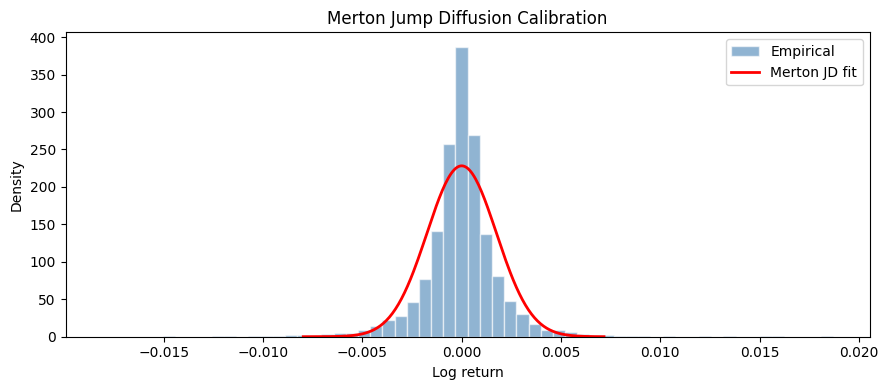

In [12]:
# Visualize: empirical vs fitted PDF
import matplotlib.pyplot as plt

x_min, x_max = np.percentile(returns, [0.5, 99.5])
x_grid = np.linspace(x_min, x_max, 200)
pdf_fit = merton_pdf(x_grid, params["sigma"], params["lambda"], 
                     params["mu_j"], params["delta_j"], dt)

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(returns, bins=60, density=True, alpha=0.6, label="Empirical", color="steelblue", edgecolor="white")
ax.plot(x_grid, pdf_fit, "r-", lw=2, label="Merton JD fit")
ax.set_xlabel("Log return")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Merton Jump Diffusion Calibration")
plt.tight_layout()
plt.show()

In [ ]:
# Parameters for QuantLib / C++ engine (feed to algo)
calibration_output = {
    "sigma": params["sigma"],
    "lambda": params["lambda"],
    "mu_j": params["mu_j"],
    "delta_j": params["delta_j"],
}
print("Calibration output (for algo):")
for k, v in calibration_output.items():
    print(f"  {k}: {v}")

Calibration output (for algo):
  sigma: 0.5670314049255935
  lambda: 20.0
  mu_j: -0.0006370659487779015
  delta_j: 0.010898637248678735


## Phase B: C++ online calibrator experimentation

This section replays historical bars through `merton_online_calibrator` and helps you test the production setup.

What you can experiment with:

- online update cadence (`update_every_n_returns`)
- window length (`window_size`)
- MLE truncation/config (`n_max`, `coordinate_steps`)
- divergence between fast fair value and QuantLib helper fair value

In [ ]:
# Load the compiled C++ module and define helpers.
import importlib

moc = importlib.import_module("merton_online_calibrator")
print("Loaded C++ module:", moc.__file__)


def _set_lambda(obj, value: float) -> None:
    # "lambda" is a Python keyword, so use setattr/getattr.
    setattr(obj, "lambda", float(value))


def _get_lambda(obj) -> float:
    return float(getattr(obj, "lambda"))


def make_cpp_calibrator(
    initial_params: dict,
    *,
    window_size: int = 4096,
    min_points_for_update: int = 512,
    update_every_n_returns: int = 128,
    n_max: int = 15,
    coordinate_steps: int = 3,
):
    p = moc.MertonParams()
    p.sigma = float(initial_params["sigma"])
    _set_lambda(p, float(initial_params["lambda"]))
    p.mu_j = float(initial_params["mu_j"])
    p.delta_j = float(initial_params["delta_j"])

    cfg = moc.CalibratorConfig()
    cfg.window_size = int(window_size)
    cfg.min_points_for_update = int(min_points_for_update)
    cfg.update_every_n_returns = int(update_every_n_returns)
    cfg.n_max = int(n_max)
    cfg.coordinate_steps = int(coordinate_steps)

    return moc.OnlineMertonCalibrator(p, cfg)


def funding_annual(funding_rate_8h: float) -> float:
    # Convert 8h discrete funding into annualized carry.
    return (1.0 + funding_rate_8h) ** (365.25 * 3.0) - 1.0

In [ ]:
# Replay the most recent bars into the C++ online calibrator.
# Tune these values to experiment with runtime behavior.
REPLAY_BARS = 2000
FUNDING_RATE_8H = 0.0001
HORIZON_HOURS = 8.0

replay_df = ohlc_calib.tail(REPLAY_BARS).copy()
cal = make_cpp_calibrator(
    calibration_output,
    window_size=4096,
    min_points_for_update=512,
    update_every_n_returns=128,
    n_max=15,
    coordinate_steps=3,
)

q_annual = funding_annual(FUNDING_RATE_8H)
t_years = HORIZON_HOURS / (365.25 * 24.0)

records = []
updates = []

for ts, row in replay_df.iterrows():
    px = float(row["close"])
    epoch_us = int(ts.value // 1_000)  # pandas ns -> us

    accepted = cal.update_tick(px, epoch_us)
    updated = bool(accepted and cal.maybe_update_params())

    p_now = cal.params()
    lam_now = _get_lambda(p_now)

    fair_fast = float(cal.fair_value(px, q_annual, t_years, 0.0))
    fair_ql = float(cal.fair_value_quantlib(px, q_annual, t_years, 0.0))

    records.append(
        {
            "time": ts,
            "close": px,
            "fair_fast": fair_fast,
            "fair_ql": fair_ql,
            "spread_fast_bps": 1e4 * (fair_fast - px) / px,
            "spread_ql_bps": 1e4 * (fair_ql - px) / px,
            "ql_minus_fast_bps": 1e4 * (fair_ql - fair_fast) / px,
            "sigma": float(p_now.sigma),
            "lambda": lam_now,
            "mu_j": float(p_now.mu_j),
            "delta_j": float(p_now.delta_j),
            "updated": updated,
        }
    )

    if updated:
        updates.append((ts, float(p_now.sigma), lam_now, float(p_now.mu_j), float(p_now.delta_j)))

exp_df = pd.DataFrame(records).set_index("time")

print(f"Replay bars: {len(exp_df)}")
print(f"Accepted samples: {cal.sample_count()}")
print(f"Online updates triggered: {len(updates)}")
print("\nFinal online params:")
print(exp_df[["sigma", "lambda", "mu_j", "delta_j"]].tail(1).to_string())

exp_df.tail(5)

In [ ]:
# Visual diagnostics for experimentation.
import matplotlib.pyplot as plt

show_n = min(500, len(exp_df))
plot_df = exp_df.tail(show_n)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(plot_df.index, plot_df["close"], label="close", lw=1.5)
axes[0].plot(plot_df.index, plot_df["fair_fast"], label="fair_fast", lw=1.2)
axes[0].plot(plot_df.index, plot_df["fair_ql"], label="fair_ql", lw=1.0, alpha=0.9)
axes[0].set_title("Market close vs theoretical fair values")
axes[0].legend(loc="upper left")
axes[0].grid(alpha=0.3)

axes[1].plot(plot_df.index, plot_df["spread_fast_bps"], label="fast spread (bps)")
axes[1].plot(plot_df.index, plot_df["spread_ql_bps"], label="ql spread (bps)", alpha=0.9)
axes[1].axhline(0.0, color="black", lw=1)
axes[1].set_title("Fair - market spread in bps")
axes[1].legend(loc="upper left")
axes[1].grid(alpha=0.3)

axes[2].plot(plot_df.index, plot_df["sigma"], label="sigma")
axes[2].plot(plot_df.index, plot_df["lambda"], label="lambda")
axes[2].plot(plot_df.index, plot_df["delta_j"], label="delta_j")
axes[2].set_title("Online parameter evolution")
axes[2].legend(loc="upper left")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

if updates:
    updates_df = pd.DataFrame(
        updates,
        columns=["time", "sigma", "lambda", "mu_j", "delta_j"],
    ).set_index("time")
    display(updates_df.tail(10))
else:
    print("No online parameter updates were triggered. Try increasing REPLAY_BARS or reducing min_points_for_update.")

### Suggested experiments

1. **Stability vs responsiveness**
   - lower `min_points_for_update` and `update_every_n_returns` for faster adaptation
   - increase them for smoother, less noisy parameters

2. **Likelihood truncation sensitivity**
   - vary `n_max` (e.g. `10`, `15`, `20`) and compare spread distributions

3. **QuantLib helper divergence**
   - monitor `ql_minus_fast_bps`; it should usually stay small
   - spikes can indicate carry assumptions (`FUNDING_RATE_8H`, `HORIZON_HOURS`) need adjustment

4. **Deployment seed selection**
   - use final rows from `exp_df[["sigma", "lambda", "mu_j", "delta_j"]]` as candidate runtime seeds